#Map The Problem


#Transverse Field Ising model to demo Primitives


In [13]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import YGate, UnitaryGate
import numpy as np

SYGate = UnitaryGate(YGate().power(1/2), label=r"$\sqrt{Y}$")
SYdgGate = UnitaryGate(SYGate.inverse(), label=r"$\sqrt{Y}^\dag$")
def generate_1D_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers = False, layer_barriers = False):
    qc = QuantumCircuit(num_qubits)

    for trotter_step in range(num_trotter_steps):
        add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers)
        if trotter_barriers:
            qc.barrier()

    return qc

def add_1d_tfim_trotter_layer(qc, rx_angle, layer_barriers = False):
    #Adding Rzz in the even layers
    for i in range(0, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    #Adding Rzz in the odd layers
    for i in range(1, qc.num_qubits-1, 2):
        qc.sdg([i, i+1])
        qc.append(SYGate, [i+1])
        qc.cx(i, i+1)
        qc.append(SYdgGate, [i+1])
    if layer_barriers:
        qc.barrier()
    qc.rx(rx_angle, list(range(qc.num_qubits)))
    if layer_barriers:
        qc.barrier()

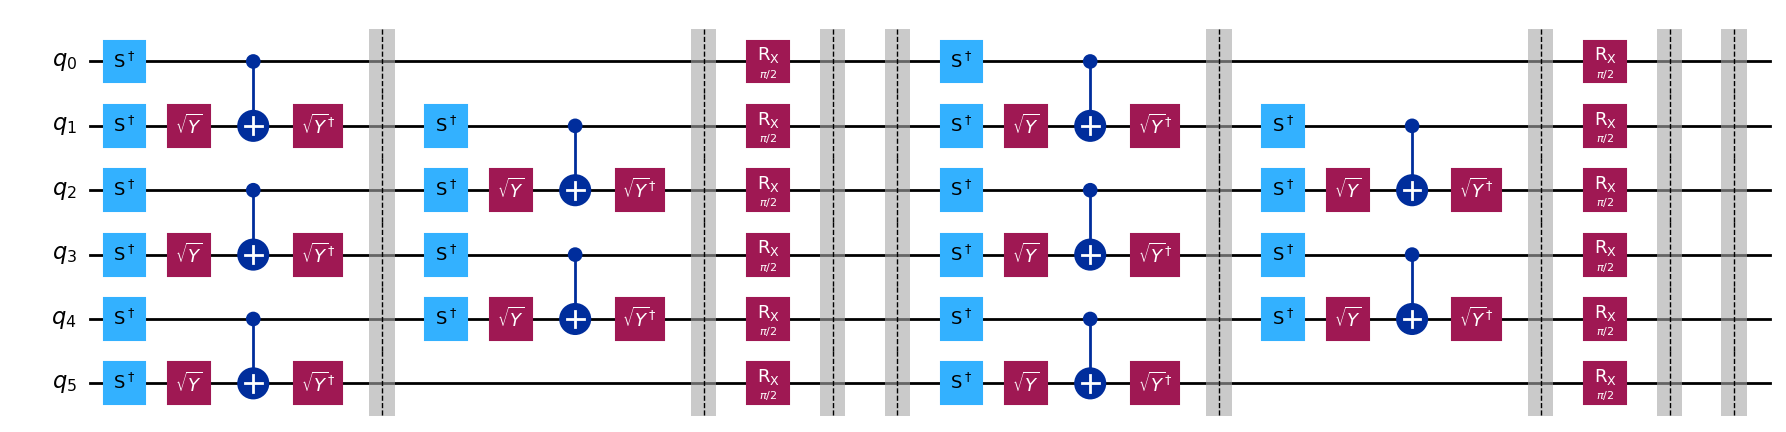

In [16]:
num_qubits = 6
num_trotter_steps = 2
rx_angle = 0.5 * np.pi

qc = generate_1D_tfim_circuit(num_qubits, num_trotter_steps, rx_angle, trotter_barriers=True, layer_barriers=True)
qc.draw(output='mpl', fold=-1)